In [26]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/platesv2"))

# Any results you write to the current directory are saved as output.
import zipfile
with zipfile.ZipFile('../input/platesv2/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))


['sample_submission.csv', 'plates.zip']
After zip extraction:
['submission1.csv', '.ipynb_checkpoints', 'plates', '__notebook_source__.ipynb', '__MACOSX']


In [27]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['.DS_Store', 'train', 'test']


In [28]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 3853.37it/s]


In [29]:
!ls train

cleaned  dirty


In [30]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [31]:
len(train_dataloader), len(train_dataset)

(5, 34)

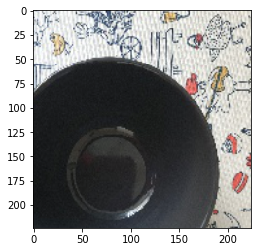

In [32]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

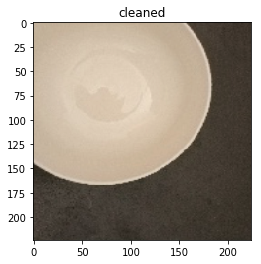

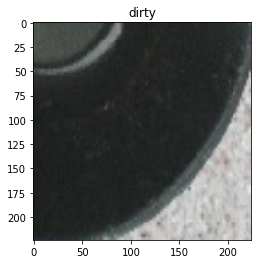

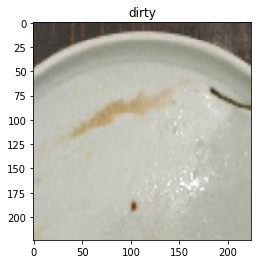

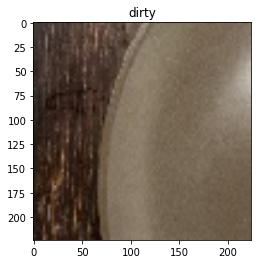

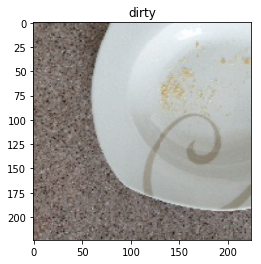

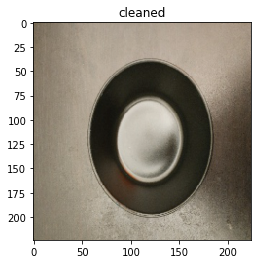

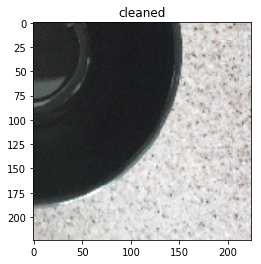

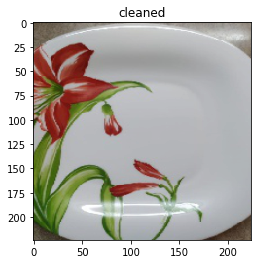

In [33]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [34]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return model

In [35]:
model = models.resnet50(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(model.fc.in_features, 2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.2)

In [36]:
train_model(model, loss, optimizer, scheduler, num_epochs=30);

Epoch 0/29:


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
100%|██████████| 5/5 [00:00<00:00,  7.74it/s]

train Loss: 1.0143 Acc: 0.5000



100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

val Loss: 1.2462 Acc: 0.5000
Epoch 1/29:



100%|██████████| 5/5 [00:00<00:00,  7.19it/s]

train Loss: 1.4576 Acc: 0.5500



100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

val Loss: 3.3859 Acc: 0.5000
Epoch 2/29:



100%|██████████| 5/5 [00:00<00:00,  8.40it/s]

train Loss: 1.8394 Acc: 0.6000



100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

val Loss: 1.0946 Acc: 0.6667
Epoch 3/29:



100%|██████████| 5/5 [00:00<00:00,  8.86it/s]

train Loss: 0.7954 Acc: 0.5750



100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

val Loss: 2.8286 Acc: 0.6667
Epoch 4/29:



100%|██████████| 5/5 [00:00<00:00,  8.79it/s]

train Loss: 2.4664 Acc: 0.5500



100%|██████████| 1/1 [00:00<00:00,  1.97it/s]

val Loss: 1.1413 Acc: 0.5000
Epoch 5/29:



100%|██████████| 5/5 [00:00<00:00,  8.80it/s]


train Loss: 0.2799 Acc: 0.9000


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

val Loss: 1.0120 Acc: 0.6667
Epoch 6/29:



100%|██████████| 5/5 [00:00<00:00,  8.71it/s]

train Loss: 0.3838 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

val Loss: 0.8953 Acc: 0.8333
Epoch 7/29:



100%|██████████| 5/5 [00:00<00:00,  8.82it/s]

train Loss: 0.1944 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

val Loss: 0.8420 Acc: 0.6667
Epoch 8/29:



100%|██████████| 5/5 [00:00<00:00,  8.72it/s]

train Loss: 1.0282 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

val Loss: 0.9223 Acc: 0.6667
Epoch 9/29:



100%|██████████| 5/5 [00:00<00:00,  8.61it/s]

train Loss: 0.5382 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

val Loss: 1.4090 Acc: 0.6667
Epoch 10/29:



100%|██████████| 5/5 [00:00<00:00,  7.32it/s]

train Loss: 0.7696 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

val Loss: 0.8568 Acc: 0.6667
Epoch 11/29:



100%|██████████| 5/5 [00:00<00:00,  7.92it/s]

train Loss: 0.3179 Acc: 0.8000



100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

val Loss: 0.7716 Acc: 0.6667
Epoch 12/29:



100%|██████████| 5/5 [00:00<00:00,  8.63it/s]

train Loss: 0.5189 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

val Loss: 0.7624 Acc: 0.6667
Epoch 13/29:



100%|██████████| 5/5 [00:00<00:00,  8.46it/s]

train Loss: 0.1395 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

val Loss: 0.8364 Acc: 0.6667
Epoch 14/29:



100%|██████████| 5/5 [00:00<00:00,  8.80it/s]

train Loss: 0.1175 Acc: 0.9500



100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

val Loss: 0.8672 Acc: 0.6667
Epoch 15/29:



100%|██████████| 5/5 [00:00<00:00,  8.62it/s]

train Loss: 0.3044 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

val Loss: 0.8367 Acc: 0.6667
Epoch 16/29:



100%|██████████| 5/5 [00:00<00:00,  8.75it/s]

train Loss: 0.0832 Acc: 1.0000



100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

val Loss: 0.9161 Acc: 0.6667
Epoch 17/29:



100%|██████████| 5/5 [00:00<00:00,  8.34it/s]

train Loss: 0.2594 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

val Loss: 1.0549 Acc: 0.6667
Epoch 18/29:



100%|██████████| 5/5 [00:00<00:00,  8.65it/s]

train Loss: 0.4177 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

val Loss: 0.9951 Acc: 0.6667
Epoch 19/29:



100%|██████████| 5/5 [00:00<00:00,  8.33it/s]

train Loss: 0.3389 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

val Loss: 1.0411 Acc: 0.6667
Epoch 20/29:



100%|██████████| 5/5 [00:00<00:00,  7.53it/s]

train Loss: 0.2233 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

val Loss: 1.0685 Acc: 0.6667
Epoch 21/29:



100%|██████████| 5/5 [00:00<00:00,  8.67it/s]

train Loss: 0.3065 Acc: 0.9000



100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

val Loss: 1.0458 Acc: 0.6667
Epoch 22/29:



100%|██████████| 5/5 [00:00<00:00,  8.47it/s]

train Loss: 0.2375 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

val Loss: 1.0387 Acc: 0.6667
Epoch 23/29:



100%|██████████| 5/5 [00:00<00:00,  8.69it/s]

train Loss: 0.3866 Acc: 0.8250



100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

val Loss: 0.9158 Acc: 0.6667
Epoch 24/29:



100%|██████████| 5/5 [00:00<00:00,  8.72it/s]


train Loss: 0.3442 Acc: 0.8750


100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

val Loss: 0.9668 Acc: 0.6667
Epoch 25/29:



100%|██████████| 5/5 [00:00<00:00,  8.64it/s]


train Loss: 0.5603 Acc: 0.7250


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

val Loss: 0.7765 Acc: 0.6667
Epoch 26/29:



100%|██████████| 5/5 [00:00<00:00,  8.55it/s]

train Loss: 0.0840 Acc: 0.9750



100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

val Loss: 0.8774 Acc: 0.6667
Epoch 27/29:



100%|██████████| 5/5 [00:00<00:00,  8.44it/s]

train Loss: 0.3874 Acc: 0.6750



100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

val Loss: 0.7363 Acc: 0.6667
Epoch 28/29:



100%|██████████| 5/5 [00:00<00:00,  8.59it/s]

train Loss: 0.2748 Acc: 0.9250



100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

val Loss: 0.9585 Acc: 0.6667
Epoch 29/29:



100%|██████████| 5/5 [00:00<00:00,  8.38it/s]

train Loss: 0.3741 Acc: 0.8500



100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

val Loss: 0.8777 Acc: 0.6667


In [37]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [38]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [39]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [40]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [00:05<00:00, 16.68it/s]


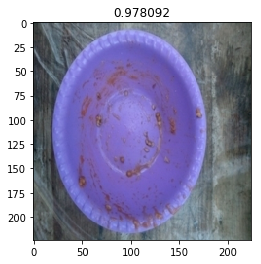

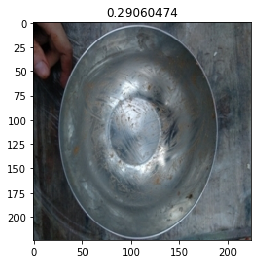

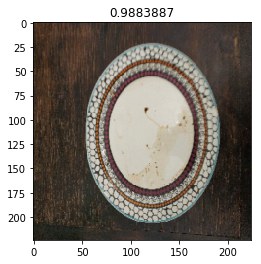

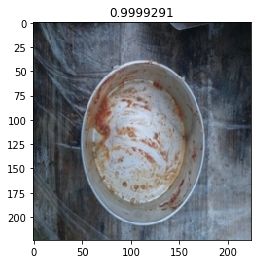

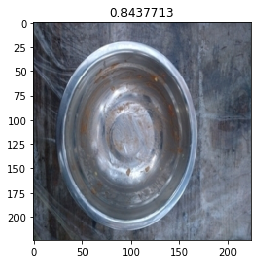

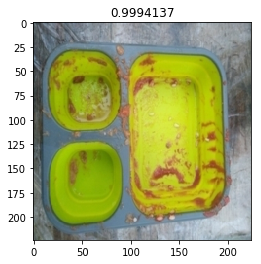

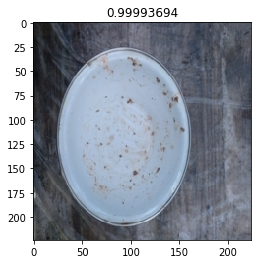

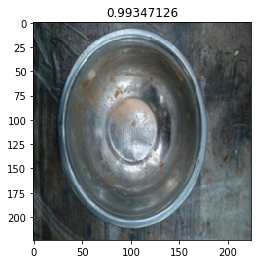

In [41]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [42]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [43]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,cleaned
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [44]:
submission_df.to_csv('submission1.csv')

In [45]:
!rm -rf train val test